# Project 2: Reproducibility in Natural Language Processing



### Read Data

In [4]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

plt.style.use('seaborn-v0_8-dark')

In [5]:
!{sys.executable} -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 70.3 MB/s  0:00:00m0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
sou = pd.read_csv("data/SOTU.csv")

In [7]:
import spacy
from tqdm import tqdm
from collections import Counter

nlp = spacy.load("en_core_web_sm")

## Part 3: Advanced Text Processing - LDA and BERTopic Topic Modeling (20 pts)

**Resources:**
- LDA:
    - https://medium.com/sayahfares19/text-analysis-topic-modelling-with-spacy-gensim-4cd92ef06e06 
    - https://www.kaggle.com/code/faressayah/text-analysis-topic-modeling-with-spacy-gensim#%F0%9F%93%9A-Topic-Modeling (code for previous post)
    - https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf/ 
- BERTopic:
    - https://maartengr.github.io/BERTopic/getting_started/visualization/visualize_documents.html#visualize-documents-with-plotly 
    - https://maartengr.github.io/BERTopic/getting_started/visualization/visualize_topics.html 


In [8]:
from spacy import displacy
from bertopic import BERTopic
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.gensim_models

/home/jovyan/.local/share/envs/sotu/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### LDA

- Train an LDA model with 18 topics
- Output the top 10 words for each topic. 
- Output the topic distribution for the first speech
- Make a visualization

You may use the next two cells to process the data.

In [9]:
def preprocess_text(text):
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc if not token.is_stop and not
            token.is_punct and not token.is_space and len(token.lemma_) > 3]

In [10]:
# Process all texts - note this takes ~ 5 minutes to run
processed_docs = sou['Text'].apply(preprocess_text)

To train an LDA model, use the LdaModel function that we imported a couple of cells back. The last resource linked under the LDA section is especially useful for walking through the steps we have below. *Note: one of the arguments to the LdaModel function is `random_state` which specifies the random seed for reproducibility. Please set yours to 42. Further, the last resource provided uses `LdaMulticore` which is essentially a parallelizable version of our function `LdaModel`. Use `LdaModel` instead, but the usage will be similar, except you can ignore the `iterations` and `workers` arguments..*.

In [11]:
# Build dictionary from processed_docs, which is a list of tokens extracted from our speeches
dictionary = Dictionary(processed_docs)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [12]:
# train LDA model with 18 topics
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
model_LDA = LdaModel(corpus=corpus, id2word=dictionary, num_topics=18, random_state=42)

In [13]:
# print the top 10 words for each topic
model_LDA.print_topics()

[(0,
  '0.007*"mexico" + 0.005*"spain" + 0.004*"island" + 0.004*"minister" + 0.004*"convention" + 0.004*"port" + 0.004*"article" + 0.004*"program" + 0.003*"june" + 0.003*"indians"'),
 (1,
  '0.005*"program" + 0.004*"today" + 0.004*"cent" + 0.004*"note" + 0.004*"americans" + 0.004*"tariff" + 0.004*"island" + 0.004*"budget" + 0.004*"indians" + 0.003*"indian"'),
 (2,
  '0.015*"americans" + 0.011*"program" + 0.009*"tonight" + 0.008*"billion" + 0.008*"challenge" + 0.007*"budget" + 0.006*"fight" + 0.005*"percent" + 0.005*"thank" + 0.005*"worker"'),
 (3,
  '0.005*"convention" + 0.004*"cent" + 0.004*"minister" + 0.004*"note" + 0.004*"june" + 0.004*"method" + 0.004*"actual" + 0.003*"tariff" + 0.003*"railroad" + 0.003*"port"'),
 (4,
  '0.005*"americans" + 0.005*"mexico" + 0.004*"convention" + 0.004*"gold" + 0.004*"june" + 0.004*"spain" + 0.003*"island" + 0.003*"british" + 0.003*"indian" + 0.003*"currency"'),
 (5,
  '0.010*"americans" + 0.008*"tonight" + 0.007*"program" + 0.006*"today" + 0.004*"b

In [14]:
# print the topic distribution for the first speech
model_LDA[corpus][0]

[(2, np.float32(0.9988718))]

In [24]:
# make a visualization using pyLDAvis
pyLDAvis.enable_notebook()

lda_display = pyLDAvis.gensim_models.prepare(model_LDA, corpus, dictionary)

import os
output_dir = "outputs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

html_output_path = os.path.join(output_dir, "pyLDAvis_interactive.html")
pyLDAvis.save_html(lda_display, html_output_path)
pyLDAvis.display(lda_display)

### BERTopic

- Train a BERTopic model with a `min_topic_size` of 3 *Hint: use `BERTopic` to instantiate the model and specify `min_topic_size` in here. Actually fit the model using `fit_transform`, which `docs` passed into this.*
- Output the top 10 words for each topic. 
- Output the topic distribution for the first speech
- Make a visualization of the topics (see topic_model.visualize_topics())

In [16]:
docs = sou['Text'].to_list()

In [17]:
# train the model - this takes about 30 seconds
model = BERTopic(min_topic_size=3, verbose=True)
topics, probs = model.fit_transform(docs)

2025-11-21 23:51:23,167 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:10<00:00,  1.26s/it]
2025-11-21 23:51:36,925 - BERTopic - Embedding - Completed ✓
2025-11-21 23:51:36,926 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-21 23:51:48,119 - BERTopic - Dimensionality - Completed ✓
2025-11-21 23:51:48,121 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-21 23:51:48,137 - BERTopic - Cluster - Completed ✓
2025-11-21 23:51:48,185 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-21 23:51:49,776 - BERTopic - Representation - Completed ✓


In [18]:
# remove stop words from the topics (Hint: use CountVectorizer and then .update_topics on topic_model)
vector = CountVectorizer(stop_words='english')
model.update_topics(docs, vectorizer_model=vector)

In [19]:
# output the top 10 words for each topic - hint see get_topic_info
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,45,-1_government_states_united_congress,"[government, states, united, congress, year, p...",[\nJump toPart II |Part III\nPart 1. [On Our F...
1,0,88,0_america_world_new_people,"[america, world, new, people, american, years,...","[\nMr. President, Mr. Speaker, Members of the ..."
2,1,14,1_states_government_public_country,"[states, government, public, country, congress...",[\nFellow-Citizens of the Senate and House of ...
3,2,12,2_government_states_united_department,"[government, states, united, department, congr...",[\nFellow-Citizens of the Senate and House of ...
4,3,11,3_states_united_government_public,"[states, united, government, public, mexico, c...",[\nFellow-Citizens of the Senate and House of ...
5,4,10,4_government_states_law_united,"[government, states, law, united, year, gold, ...",[\nTo the Senate and House of Representatives:...
6,5,8,5_government_work_great_congress,"[government, work, great, congress, public, la...",[\nTo the Senate and House of Representatives:...
7,6,7,6_government_states_united_world,"[government, states, united, world, free, peop...","[\nMr. President, Mr. Speaker, Members of the ..."
8,7,6,7_states_government_constitution_country,"[states, government, constitution, country, ge...",[\nFellow-Citizens of the Senate and House of ...
9,8,5,8_national_federal_reduction_public,"[national, federal, reduction, public, ought, ...",[\n[ As delivered in person before a joint ses...


100%|██████████| 1/1 [00:13<00:00, 13.56s/it]


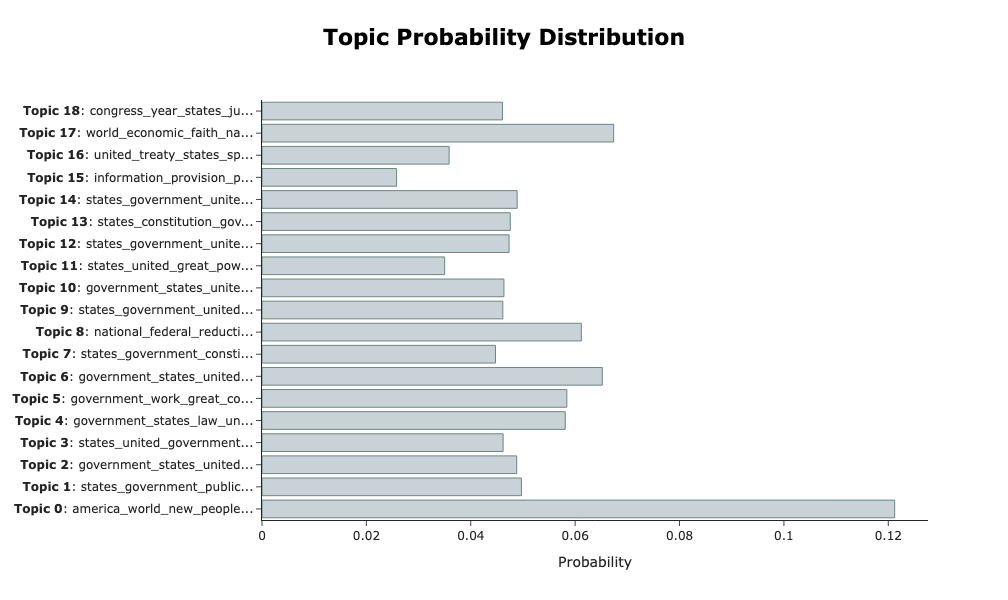

In [40]:
# output the topic distribution for the first speech
# hint: check out approximate_distribution() and visualize_distribution()
topic_distr, _ = model.approximate_distribution(docs, min_similarity=0)
fig = model.visualize_distribution(topic_distr[0])
output_path = os.path.join(output_dir, "topic_distribution_plot.png")
# fig.save_html(output_path) # bbox_inches='tight' prevents labels from being cut off
fig.write_html("outputs/viz_distribution.html")
fig.show()

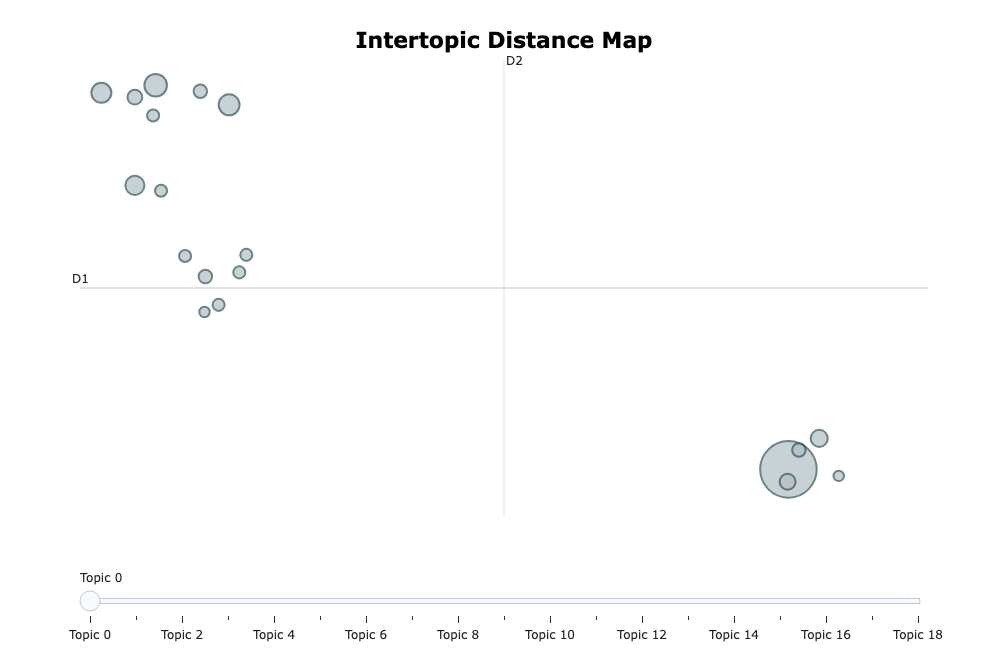

In [42]:
# run this cell to visualize the topics
fig = model.visualize_topics()
fig.write_html("outputs/topic_distribution.html")
fig.show()